In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
     $('div.prompt').hide();
     $('div.input').hide();
 } else {
     $('div.input').show();
     $('div.prompt').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the code."></form>
''')

# Assignment 01 - IBM ML.

#### Made by: Alessandro Manfredini

## Analysis of temperature data: is global warming real?

Of course this is just an exercise, we all know global warming is real. However, I was interested to see how significant the effect is with a simple analysis. It turns out is very significant.

The study aims to evaluate the significance of the deviation of the average temperature, in one specific location, in the recent years with respect to a point in time. In summary can be summarized in the following parts:

- Evaluate data quality and asses a potential region where to conduct the analisys
- Define a reference time t0.
- Define a control time t1. 
- H0 assumes that the temperature does not change over time. So under H0, the average temperature difference between t1 and t0 is a random variable expected to be distributed as a Gaussian centered in zero.
- Evaluate the standard deviation of that distribution.
- Evaluate the p-value of H0.


## The dataset

The used dataset was taken from [kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data), which is a repackaging of the Berkley Earth dataset on global temperatures. In particular I concentrated on the dataset that contains temperature reading per each month and per city since 1740. The dataset has the following features:
- Timestamp
- Average Temperature over a month
- Temperature measure uncertainty
- City
- Country
- Coordinates

For this analysis I considered only one location, Rome. The notebook relative to this analysis can be foun [here](https://github.com/panManfredini/IBM_ML/blob/main/01_ReadingData/project_assignment_1.ipynb).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats
pd.options.display.max_rows = 100000

In [3]:
df = pd.read_csv("data/global_warming/GlobalLandTemperaturesByCity.csv", parse_dates=[0])

## Data Quality Assessment amd feature engineering

There is a large number of NA values, especially for early years, also the number of observation reported for early years is much lower, due to the fact that there weren't measurements for certain cities, or that city perhaps not developed yet.
This is shown in the figure below.

In [4]:
df_counts = (df.groupby(df.dt.dt.year)
             .count()
             .rename(columns={"dt":"total_counts","AverageTemperature":"Not_na_counts"})
             .reset_index()
            )

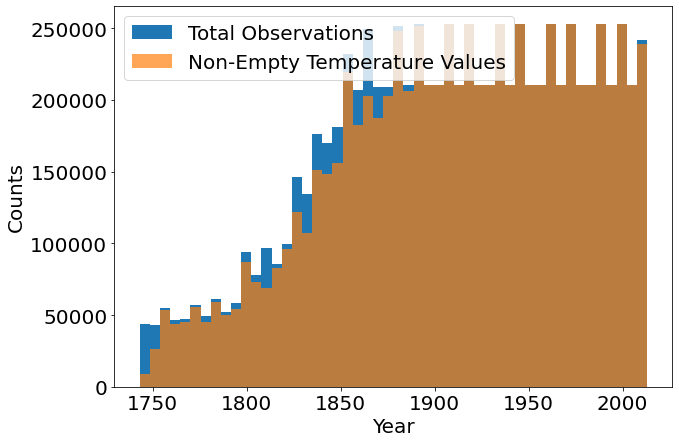

In [5]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.hist(df_counts.dt, weights=df_counts.total_counts, bins=50 )
plt.hist(df_counts.dt, weights=df_counts.Not_na_counts, bins=50, alpha=0.7)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.legend(["Total Observations","Non-Empty Temperature Values"],fontsize=20)
plt.show()

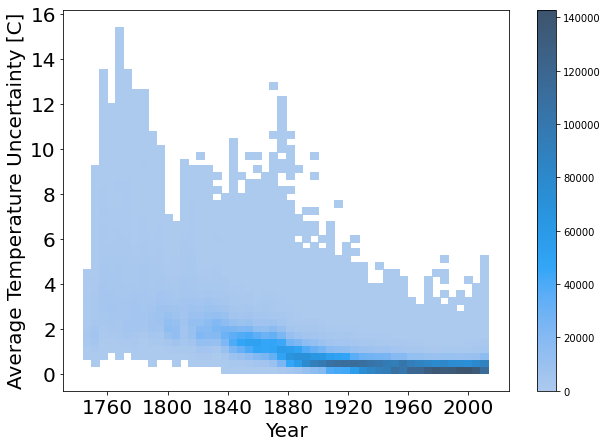

In [6]:
fig, ax2 = plt.subplots(figsize=(10,7))
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Average Temperature Uncertainty [C]',fontsize=20)
sns.color_palette("mako", as_cmap=True)
sns.histplot(x="dt", y="AverageTemperatureUncertainty", data=df, bins=50, cbar=True)
plt.show()

The uncertainty on the temperature has a large variance for years below 1900 and it is relatively higher due to tecnology difference. 
Now in this analysis we need a representative sample of temperatures from the past and a representative sample of temperature of the present. Since the data is by city, and data from many cities are missing in the past this can affect the outcome of the analysis (we need to compare to the same locations). Also the uncertainty of the temperature measurments is correlated with the year, beacuase of technology advancement. Because of this I decided then to only use data above year 1900 for the final hypothesis test, because has very few missing values and is more uniform in measurement uncertainty.

#### Data cleansing
So for data cleansing we simply drop all years below 1900, and cross check that for the chosen location Rome, all data are present.

#### Feature engineering

It was usefull to derive a few quantities necessary for the evaluations:
- Reduced size datasets only with Rome, Paris and Melbourne
- The average value of temperature reading per month grouped every 20 years
- Standard deviation per month grouped every 20 years for the t0

## Data Exploration

One of the aim of data exploration is to cross check few of the features that we expect in the dataset and validate the assumptions made, for then proceed with hypothesis test. As an example I crosschecked the correlation of temperature readings of neghboring cities. 

As a first study you can see below the distribution of temperature values in Rome since 1800 for 3 different months: January, April and August. This shows that temperature per month need to be treated separately, because the temperature per year is not distributed as a Gaussian.

In [7]:
df_1900 = df.loc[df.dt.dt.year > 1800 ]
df_Rome = df_1900[df_1900.loc[:,"City"] == "Rome" ]
df_Paris = df_1900[df_1900.loc[:,"City"] == "Paris" ]

In [8]:
df_Melbourne = df_1900[df_1900.loc[:,"City"] == "Melbourne" ]

In [9]:
# adding the column Month and year for easy access
df_Rome = df_Rome.assign(Month=df_Rome.dt.dt.month)
df_Rome = df_Rome.assign(Year=df_Rome.dt.dt.year)

In [10]:
df_Rome_sub_months = df_Rome[df_Rome.Month.isin([1,4,8])]

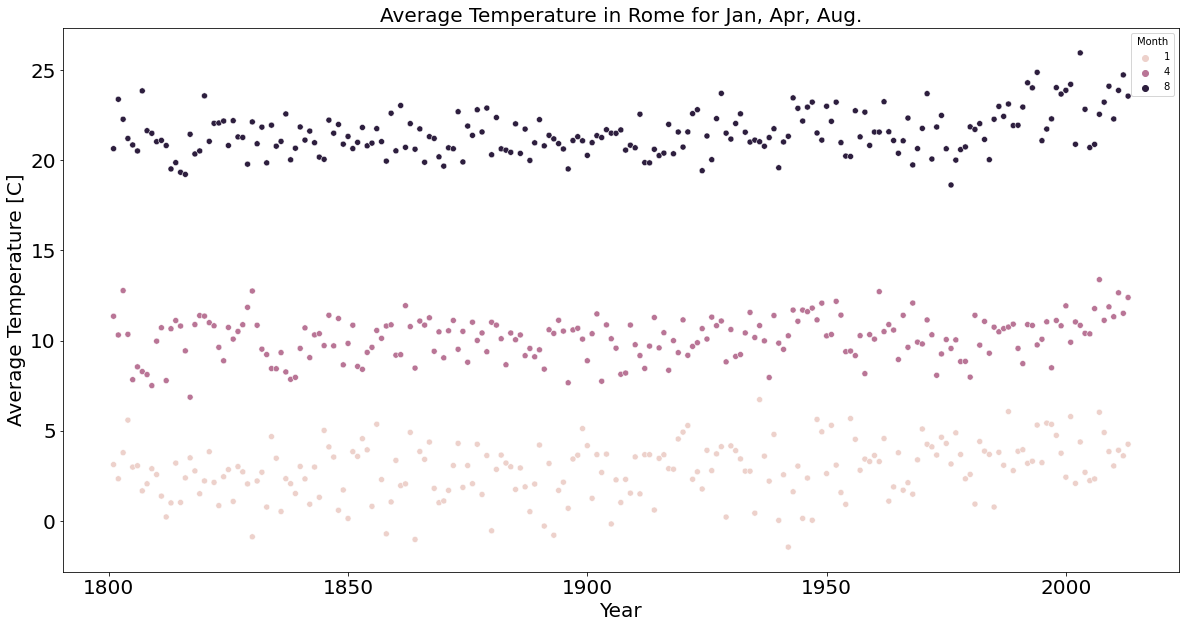

In [11]:
fig, ax3 = plt.subplots(figsize=(20,10))
ax3.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Average Temperature [C]',fontsize=20)
plt.legend(["January","April","August"],fontsize=20)
plt.title("Average Temperature in Rome for Jan, Apr, Aug.", fontsize=20)
sns.scatterplot(x="Year",y="AverageTemperature",data=df_Rome_sub_months, hue="Month", ax=ax3)
plt.show()

#### Seasonal Correlation

As an example here we can study the expected correlation and anticorrelation originated by the earth rotational axis orientation and position with respect to the sun (the confounding variable). In particular we expect that two locations in the same emisphere would have correlated temperature readings (because of seasonal change), whereas temperature readings in different emispheres will be anti-correlated. This is what we see in the following two plots, where we compare the temperature readings in the last 100 years of Rome, Paris and Melbourne.

In [12]:
# Exercise plot correlation rome Paris and anticorrelation rome-sindey
# done by setting dt as index and aligning the two df
df_Rome_tidx = df_Rome.set_index("dt")
df_Paris_tidx = df_Paris.set_index("dt")
df_Melbourne_tidx = df_Melbourne.set_index("dt")


In [13]:
temp = df_Rome_tidx.assign(Avg_Paris=df_Paris_tidx.AverageTemperature)
df_mixed_cities = temp.assign(Avg_Melbourne=df_Melbourne_tidx.AverageTemperature)


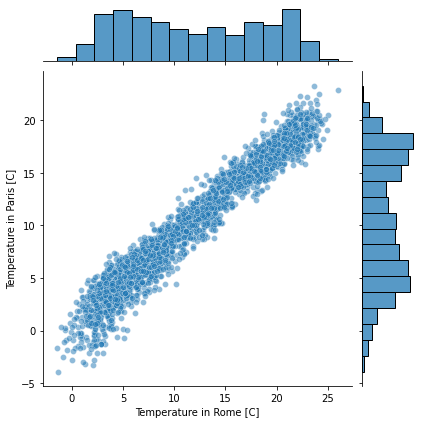

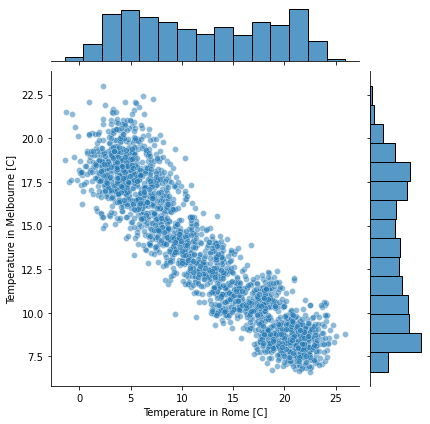

In [14]:
jp1 = sns.jointplot(data=df_mixed_cities, x="AverageTemperature",y="Avg_Paris", alpha=0.5 )
jp1.set_axis_labels("Temperature in Rome [C]","Temperature in Paris [C]")
jp2 = sns.jointplot(data=df_mixed_cities, x="AverageTemperature",y="Avg_Melbourne", alpha=0.5)
jp2.set_axis_labels("Temperature in Rome [C]","Temperature in Melbourne [C]")
plt.show()

#### Gaussianity assumption cross check
One of the main assumption for this analysis is that the temperature per single month and location has a Gaussian distribution. This is true of course for a period of time where global warming is absent. Below is shown distribution of temperature in Rome for June years 1800-1900. Considering the small amount of sample the assumption can be considered acceptable.

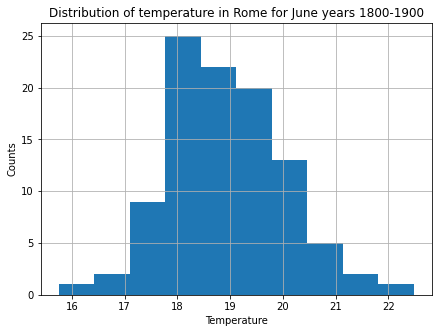

The standard deviation for the temperature sample of June is 1.1 C


In [15]:
df_1800 = df_Rome[(df_Rome.Year>=1800)&(df_Rome.Year<=1900)]
fig, ax = plt.subplots(figsize=(7,5))
plt.xlabel("Temperature")
plt.ylabel("Counts")
plt.title("Distribution of temperature in Rome for June years 1800-1900")
df_1800[df_1800.Month == 6].AverageTemperature.hist()
plt.show()
check_std = df_1800[df_1800.Month == 6].AverageTemperature.std()
print("The standard deviation for the temperature sample of June is {0:1.1f} C".format(check_std))

#### Average temperature evolution

The next plot shows the distribution of the average temperature (over the whole year) as a function of time, grouped every 20 years. It is clear that there is pertubation in the trend starting from about 1925 (is this because of WW2?).

In [16]:
df_h0 = df_Rome.loc[(df_Rome.dt.dt.year <= 1920)&(df_Rome.dt.dt.year >= 1900) ]

In [17]:
sn_h0_month_mean = df_h0.groupby(by="Month")["AverageTemperature"].mean()
sn_h0_month_std = df_h0.groupby(by="Month")["AverageTemperature"].std()

In [18]:
# filling the std_residuals per month
temp_data = []
for month in list(sn_h0_month_mean.index):
    temp_data.append((df_Rome.loc[df_Rome.Month == month].AverageTemperature - sn_h0_month_mean[month]) / sn_h0_month_std[month])

residuals = pd.concat(temp_data)

In [19]:
df_Rome_residuals = df_Rome.assign(std_residual=residuals)

In [20]:
average_std = sn_h0_month_std.mean()
months = 12
grouped_years = 20
avg_residual_err = average_std * math.sqrt( 2 / months / grouped_years)

In [21]:
year_group_bins = np.arange(1800,2020, grouped_years)
a_sum_T,bins = np.histogram(df_Rome.Year, bins=year_group_bins, weights=df_Rome.AverageTemperature)
a_sum_n,bins = np.histogram(df_Rome.Year, bins=year_group_bins)
a_res_mean = ((a_sum_T / a_sum_n) - sn_h0_month_mean.mean())/avg_residual_err
a_mean = (a_sum_T / a_sum_n)
years = (bins[:-1] + bins[1:])/2
error_mean = average_std * math.sqrt( 1 / months / grouped_years)

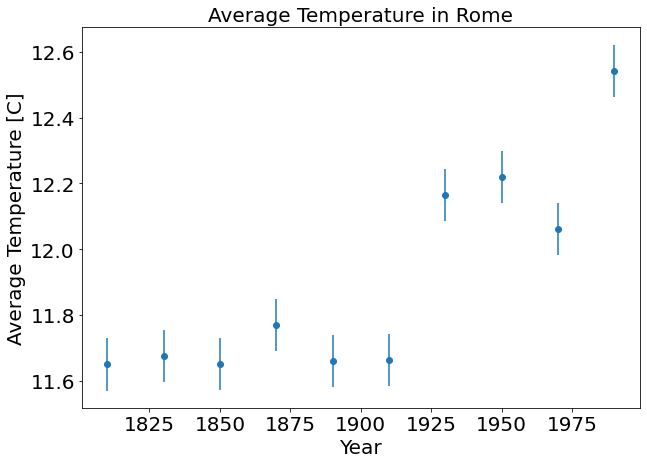

In [22]:
fig, ax9 = plt.subplots(figsize=(10,7))
ax9.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Average Temperature [C]',fontsize=20)
plt.title("Average Temperature in Rome", fontsize=20)
plt.errorbar(years,a_mean, yerr=error_mean, fmt="o")
plt.show()

#### Standardized residual with 1900 in Rome

Altough is clear that there is something going on after 1925 from the above plot, it is helpull to show it also in terms of the standardized residual with respect to a point in time. My chosen **t0** is the year range between 1900-1920 in Rome. This is the base to compute all the quantities relative to the hypothesis H0.

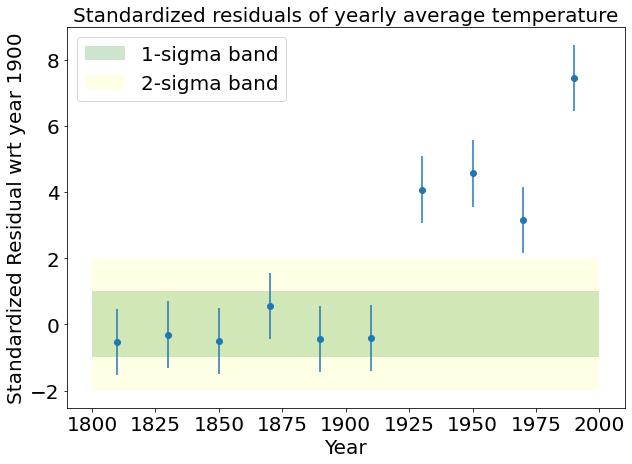

In [23]:
fig, ax4 = plt.subplots(figsize=(10,7))
ax4.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Standardized Residual wrt year 1900',fontsize=20)
plt.title("Standardized residuals of yearly average temperature", fontsize=20)
line_x = np.arange(1800,2020,20)
ax4.fill_between(line_x, -1, 1, facecolor='green', alpha=0.2)
ax4.fill_between(line_x, -2, 2, facecolor='yellow', alpha=0.1)
plt.legend(["1-sigma band","2-sigma band"],fontsize=20)
plt.errorbar(years,a_res_mean, yerr=1, fmt="o")
plt.show()

## Hypothesis testing

There are many hypothesis one could test, as an exercise I can mention 3:

- H0: Rome is hotter than Paris
- H0: Cities on the northern emisphere are hotter than the ones in the sothern hemisphere
- H0: Average temperature does not change as a funtion of the time.

I chose to perform hypothesis test on the last hypothesis, the one on global warming, does the average temperature change with time? Or in a more quantitative way: is the sample of average temperature in time range **t1** [1993-2013] extracted from the same distribution as the one in time range **t0** [1900-1920].

To do this one needs to observe that the average temperature per month over a set of years is distributed as a gaussian with standard deviation of about 1 C. If H0 is true then the difference in average temp. per month between **t0** and **t1** is again distributed as a Gaussian and centered in zero. If one then takes the average of such differences, yhis is also gaussian distributed around zero and with standard deviation that can be calculated via error propagation. Normalizing the average of temperature **t1 - t0** by the standard deviation one obtain a test statitic that is ditributed under H0 normally with mean zero and std 1.

Once this is done I set a significance level alpha equal to 0.05 and copute the p-value for H0 as described above. I obtain:

In [24]:
df_h1 = df_Rome.loc[(df_Rome.dt.dt.year >= 1993) &( df_Rome.dt.dt.year < 2013)]

In [25]:
sn_h1_month_mean = df_h1.groupby(by="Month")["AverageTemperature"].mean()
sn_h1_month_std = df_h1.groupby(by="Month")["AverageTemperature"].std()

In [26]:
h1_mean = sn_h1_month_mean.sum() / 12


In [27]:
h1_err = np.sqrt(np.square( sn_h1_month_std / np.sqrt(20) ).sum() ) / 12

In [28]:
h0_mean = sn_h0_month_mean.sum() / 12
h0_err = np.sqrt(np.square( sn_h0_month_std / np.sqrt(20) ).sum() ) / 12

In [29]:
print("The yearly Average H1 temperature is {0:.1f} +- {1:.1f} °C".format(h1_mean,h1_err))
print("The yearly Average H0 temperature is {0:.1f} +- {1:.1f} °C".format(h0_mean,h0_err))

The yearly Average H1 temperature is 13.0 +- 0.1 °C
The yearly Average H0 temperature is 11.7 +- 0.1 °C


In [30]:
t_stat = (h1_mean - h0_mean) / math.sqrt((h0_err)**2 + (h1_err)**2)
p_value = stats.norm.sf(t_stat)
print("the p-value for H0 is {0:1.2E}".format(p_value))

the p-value for H0 is 5.44E-31


The p-value is extremely low, **global warming is real**.

## Next steps

Apart for the missing data, the data quality of this dataset is quite high. However it lacks depth, meaning that would be interesting to have more informations and not only the temperature readings. Because of this I would suggest to join this dataset with others as a funtion of the year, for example with the population per city or CO2 emission per country as funtion of time. So that one can evaluate a model of the evolution of temperature change and see how this correlates with human CO2 emission.
